# **Robust yield prediction of various farm processing units**

### Problem Description:

A new fast food chain is seeing rapid expansion over the past couple of years. They
are now trying to optimize their supply chain to ensure that there are no shortages of

ingredients. For this, they’ve tasked their data science team to come up with a mod-
el that could predict the output of each food processing farm over the next few years.

These predictions could further increase the efficiency of their current supply chain
management systems.

## About Data:

### train_data:

*   date: The timestamp at which the yield of the food processing farm was measured
*   farm_id: The farm identifier that recognizes the farm food processing plant


*   ingredient_type: The type of ingredient being produced

*   yield: The yield of the plant in tonnes

### farm_data:
*   farm_id: The farm identifier that recognizes the farm food processing plant


*   founding_year: They year when the operations commenced on the farm and food processing plant.


*   num_processing_plants: The number of processing plants present on the farm
*  farm_area: The area of the farm in square meters

*   farming_company: The company that owns the farms
*   deidentified_location: The location at which the farm is present

### train_weather.csv:


*   For each location where the farms are present, the weather data is also provided by timestamp








# Import Requried Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf 
import glob
import os
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# mounting google drive to notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### I have saved seperate csv files for each farm id in other notebook ,so iam reading those csv files here.

In [ ]:
path='/content/drive/MyDrive/Capstone/farm_ids' #setting the path

In [ ]:
# create empty list
list_of_names=[] 
#The glob.glob function is used to search for all files in the directory specified by path 
#that match the pattern *.csv
for i in glob.glob(path+'/'+"*.csv"):
  list_of_names.append(i) 

In [ ]:
#create empty list
dataframes_dict ={}
#For each iteration of the loop, the line temp_df=pd.read_csv(list_of_names[i]) reads the .csv file 
#at the index i of the list list_of_names into a pandas dataframe 
for i in range (len(list_of_names)):
  temp_df=pd.read_csv(list_of_names[i])
  # dataframes_list.append(temp_df)
  dataframes_dict[i]=temp_df

In [ ]:
dataframes_dict # it has all the subsets of 10 farm id train data

{0:                      date     farm_id ingredient_type    yield   farm_area  \
 0     2016-01-01 01:00:00  fid_110884           ing_w    0.000  690.455096   
 1     2016-01-01 02:00:00  fid_110884           ing_w    0.000  690.455096   
 2     2016-01-01 03:00:00  fid_110884           ing_w    0.000  690.455096   
 3     2016-01-01 04:00:00  fid_110884           ing_w    0.000  690.455096   
 4     2016-01-01 05:00:00  fid_110884           ing_w    0.000  690.455096   
 ...                   ...         ...             ...      ...         ...   
 8778  2016-12-31 19:00:00  fid_110884           ing_w  232.071  690.455096   
 8779  2016-12-31 20:00:00  fid_110884           ing_w  189.069  690.455096   
 8780  2016-12-31 21:00:00  fid_110884           ing_w  169.958  690.455096   
 8781  2016-12-31 22:00:00  fid_110884           ing_w  169.958  690.455096   
 8782  2016-12-31 23:00:00  fid_110884           ing_w  175.418  690.455096   
 
      farming_company deidentified_location  te

In [ ]:
for i in dataframes_dict.keys():
  print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
df=dataframes_dict[9] # 9th index values are taking into df
df

,date,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01 01:00:00,fid_32954,ing_w,0.0000,2508.381,Wayne Farms,location 7369,24.4,70.0,21.1,1020.2,-1.0,1.5
1,2016-01-01 02:00:00,fid_32954,ing_w,0.0000,2508.381,Wayne Farms,location 7369,22.8,0.0,21.1,1020.2,0.0,0.0
2,2016-01-01 03:00:00,fid_32954,ing_w,0.0000,2508.381,Wayne Farms,location 7369,21.1,0.0,20.6,1020.1,0.0,0.0
3,2016-01-01 04:00:00,fid_32954,ing_w,0.0000,2508.381,Wayne Farms,location 7369,20.0,250.0,20.0,1020.0,-1.0,2.6
4,2016-01-01 05:00:00,fid_32954,ing_w,0.0000,2508.381,Wayne Farms,location 7369,19.4,0.0,19.4,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8778,2016-12-31 19:00:00,fid_32954,ing_w,61.4304,2508.381,Wayne Farms,location 7369,22.8,140.0,10.0,1021.7,0.0,5.7
8779,2016-12-31 20:00:00,fid_32954,ing_w,61.4304,2508.381,Wayne Farms,location 7369,23.3,170.0,8.9,1021.0,0.0,4.1
8780,2016-12-31 21:00:00,fid_32954,ing_w,63.0686,2508.381,Wayne Farms,location 7369,23.3,150.0,10.0,1021.1,0.0,4.1
8781,2016-12-31 22:00:00,fid_32954,ing_w,61.8400,2508.381,Wayne Farms,location 7369,22.8,160.0,10.0,1021.1,0.0,3.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   8783 non-null   object 
 1   farm_id                8783 non-null   object 
 2   ingredient_type        8783 non-null   object 
 3   yield                  8783 non-null   float64
 4   farm_area              8783 non-null   float64
 5   farming_company        8783 non-null   object 
 6   deidentified_location  8783 non-null   object 
 7   temp_obs               8783 non-null   float64
 8   wind_direction         8783 non-null   float64
 9   dew_temp               8783 non-null   float64
 10  pressure_sea_level     8783 non-null   float64
 11  precipitation          8783 non-null   float64
 12  wind_speed             8783 non-null   float64
dtypes: float64(8), object(5)
memory usage: 892.1+ KB


In [ ]:
# converting date columns into date formate
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)

In [ ]:
df.set_index('date',inplace=True) 

<AxesSubplot:xlabel='date'>

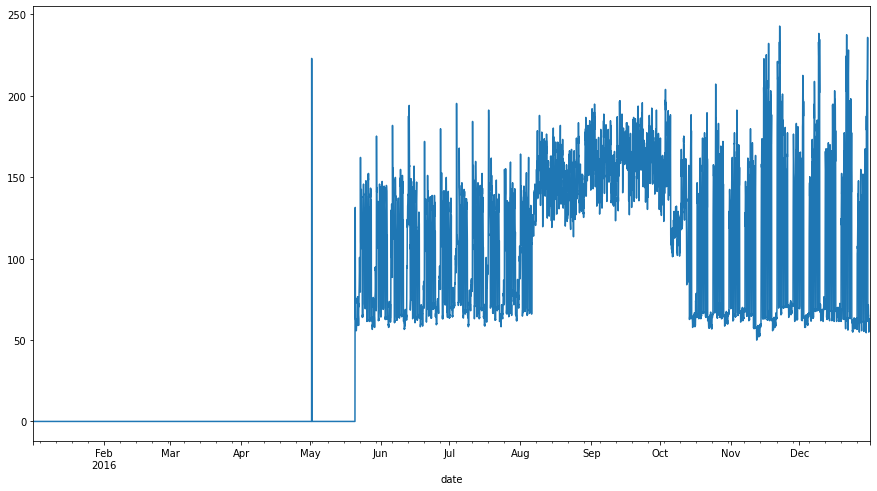

In [ ]:
df['yield'].plot(figsize=(15,8))

# Creating new input data

In [ ]:
df_input=df[['yield','farm_area','temp_obs','wind_direction','dew_temp','pressure_sea_level','precipitation','wind_speed']]

In [ ]:
#first  5 records of input_data
df_input.head()

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
date,,,,,,,,
2016-01-01 01:00:00,0.0,2508.381,24.4,70.0,21.1,1020.2,-1.0,1.5
2016-01-01 02:00:00,0.0,2508.381,22.8,0.0,21.1,1020.2,0.0,0.0
2016-01-01 03:00:00,0.0,2508.381,21.1,0.0,20.6,1020.1,0.0,0.0
2016-01-01 04:00:00,0.0,2508.381,20.0,250.0,20.0,1020.0,-1.0,2.6
2016-01-01 05:00:00,0.0,2508.381,19.4,0.0,19.4,1019.7,0.0,0.0


In [ ]:
#summary of data
df_input.describe()

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
count,8783.000000,8.783000e+03,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000
mean,72.723021,2.508381e+03,22.831868,156.785836,16.815667,1017.973528,1.382557,3.375498
std,66.861836,4.547732e-13,6.040383,117.597038,6.519312,4.038335,12.956933,2.154088
min,0.000000,2.508381e+03,1.700000,0.000000,-9.400000,992.000000,-1.000000,0.000000
25%,0.000000,2.508381e+03,18.900000,60.000000,13.300000,1015.500000,0.000000,2.100000
50%,65.525800,2.508381e+03,23.900000,140.000000,18.300000,1018.000000,0.000000,3.100000
75%,138.423000,2.508381e+03,26.700000,260.000000,22.200000,1020.500000,0.000000,4.600000
max,242.855000,2.508381e+03,36.100000,360.000000,25.600000,1030.200000,343.000000,15.400000


#### scaling data is importent to easily reach global minima during gradient decent

In [ ]:
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.        , 0.        , 0.65988372, ..., 0.7382199 , 0.        ,
        0.0974026 ],
       [0.        , 0.        , 0.61337209, ..., 0.7382199 , 0.00290698,
        0.        ],
       [0.        , 0.        , 0.56395349, ..., 0.73560209, 0.00290698,
        0.        ],
       ...,
       [0.25969653, 0.        , 0.62790698, ..., 0.7617801 , 0.00290698,
        0.26623377],
       [0.25463754, 0.        , 0.61337209, ..., 0.7617801 , 0.00290698,
        0.2012987 ],
       [0.25463754, 0.        , 0.5494186 , ..., 0.7617801 , 0.00290698,
        0.        ]])

In [ ]:
features=data_scaled
target=data_scaled[:,0]  # [:,0] selects all the elements in the first column

In [ ]:
target

array([0.        , 0.        , 0.        , ..., 0.25969653, 0.25463754,
       0.25463754])

# train_test_split

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.20,shuffle=False)

In [ ]:
X_train.shape

(7026, 8)

In [ ]:
X_test.shape

(1757, 8)

In [ ]:
24*7 #window size, I have one record  for one hour, per day 24 record ,iam taking 1 week data to predict next instance

168

In [ ]:
window_length=168
batch_size=32
num_features=8
train_generator=TimeseriesGenerator(X_train,y_train,length=window_length,sampling_rate=1,batch_size=batch_size)
test_generator=TimeseriesGenerator(X_test,y_test,length=window_length,sampling_rate=1,batch_size=batch_size)

# Model architecture 

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(window_length,num_features),return_sequences=True)) 
#return_sequences=True beacuse it is time series data we dont want to miss the sequence
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          70144     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 168, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 128)          131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 168, 128)          0         
                                                                 
 dropout (Dropout)           (None, 168, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
early_stoping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               mode='min') #monitored should be minimized
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history=model.fit_generator(train_generator,epochs=30,
                            validation_data=test_generator,
                            shuffle=False,
                            callbacks=[early_stoping])

Epoch 1/30
215/215 [==============================] - 16s 29ms/step - loss: 0.0161 - mean_absolute_error: 0.0774 - val_loss: 0.0498 - val_mean_absolute_error: 0.1842
Epoch 2/30
215/215 [==============================] - 9s 40ms/step - loss: 0.0170 - mean_absolute_error: 0.0854 - val_loss: 0.0465 - val_mean_absolute_error: 0.1818
Epoch 3/30
215/215 [==============================] - 5s 23ms/step - loss: 0.0174 - mean_absolute_error: 0.0876 - val_loss: 0.0436 - val_mean_absolute_error: 0.1787
Epoch 4/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0170 - mean_absolute_error: 0.0890 - val_loss: 0.0410 - val_mean_absolute_error: 0.1774
Epoch 5/30
215/215 [==============================] - 6s 28ms/step - loss: 0.0167 - mean_absolute_error: 0.0878 - val_loss: 0.0393 - val_mean_absolute_error: 0.1758
Epoch 6/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0157 - mean_absolute_error: 0.0852 - val_loss: 0.0363 - val_mean_absolute_error: 0.1698
Epoch 7/3

In [ ]:
model.evaluate_generator(test_generator,verbose=False)

[0.006687046494334936, 0.05752352625131607]

In [ ]:
# predict_generator will predict the test values
predictions=model.predict_generator(test_generator)

In [ ]:
predictions

array([[0.5386154 ],
       [0.55463004],
       [0.5357723 ],
       ...,
       [0.24417892],
       [0.25557673],
       [0.2611382 ]], dtype=float32)

In [ ]:
y_test

array([0.61719956, 0.62900496, 0.37942641, ..., 0.25969653, 0.25463754,
       0.25463754])

In [ ]:
X_test

array([[0.61719956, 0.        , 0.80523256, ..., 0.61780105, 0.00290698,
        0.43506494],
       [0.62900496, 0.        , 0.75872093, ..., 0.61518325, 0.00290698,
        0.46753247],
       [0.37942641, 0.        , 0.75872093, ..., 0.61256545, 0.00290698,
        0.4025974 ],
       ...,
       [0.25969653, 0.        , 0.62790698, ..., 0.7617801 , 0.00290698,
        0.26623377],
       [0.25463754, 0.        , 0.61337209, ..., 0.7617801 , 0.00290698,
        0.2012987 ],
       [0.25463754, 0.        , 0.5494186 , ..., 0.7617801 , 0.00290698,
        0.        ]])

In [ ]:
df_pred=pd.concat([pd.DataFrame(predictions),pd.DataFrame(X_test[:,1:][window_length:])],axis=1)

In [ ]:
df_pred # this all are scaled values 

,0,0,1,2,3,4,5,6
0,0.538615,0.0,0.790698,0.222222,0.728571,0.769634,0.002907,0.532468
1,0.554630,0.0,0.741279,0.250000,0.745714,0.772251,0.002907,0.331169
2,0.535772,0.0,0.726744,0.222222,0.760000,0.769634,0.002907,0.435065
3,0.327321,0.0,0.694767,0.194444,0.791429,0.774869,0.000000,0.467532
4,0.274995,0.0,0.659884,0.166667,0.760000,0.785340,0.002907,0.435065
...,...,...,...,...,...,...,...,...
1584,0.234154,0.0,0.613372,0.388889,0.554286,0.777487,0.002907,0.370130
1585,0.237782,0.0,0.627907,0.472222,0.522857,0.759162,0.002907,0.266234
1586,0.244179,0.0,0.627907,0.416667,0.554286,0.761780,0.002907,0.266234
1587,0.255577,0.0,0.613372,0.444444,0.554286,0.761780,0.002907,0.201299


#### we need original values so inverse transforming

# Reverse transforming to get the actual values

In [ ]:
rev_trans=scaler.inverse_transform(df_pred)

In [ ]:
rev_trans # here we get actual values in original formate

array([[ 130.80544432, 2508.381     ,   28.9       , ..., 1021.4       ,
           0.        ,    8.2       ],
       [ 134.69467864, 2508.381     ,   27.2       , ..., 1021.5       ,
           0.        ,    5.1       ],
       [ 130.11498765, 2508.381     ,   26.7       , ..., 1021.4       ,
           0.        ,    6.7       ],
       ...,
       [  59.30007186, 2508.381     ,   23.3       , ..., 1021.1       ,
           0.        ,    4.1       ],
       [  62.06808671, 2508.381     ,   22.8       , ..., 1021.1       ,
           0.        ,    3.1       ],
       [  63.41871775, 2508.381     ,   20.6       , ..., 1021.1       ,
           0.        ,    0.        ]])

In [ ]:
# now we have to compare predicted values and actual values

In [ ]:
df_final=df_input[predictions.shape[0]*-1:] # it will take the records from last upto prediction shape value,
# since window_length values will not come in predictions , since for camparing we want equal number of rows
#i.e it will take last 1589 records

In [ ]:
df_final.count() # it is macthes wit our prediction dataframe

yield                 1589
farm_area             1589
temp_obs              1589
wind_direction        1589
dew_temp              1589
pressure_sea_level    1589
precipitation         1589
wind_speed            1589
dtype: int64

In [ ]:
df_final['yield_pred']=rev_trans[:,0] # [:,0] selects all the elements in the first column 
# taking the yield predictions as yield_pred   and attaching to df_final

In [ ]:
# if we see df_final have yield_pred ,it consist the predictions
df_final

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
date,,,,,,,,,
2016-10-26 19:00:00,164.2240,2508.381,28.9,80.0,16.1,1021.4,0.0,8.2,130.805444
2016-10-26 20:00:00,159.3100,2508.381,27.2,90.0,16.7,1021.5,0.0,5.1,134.694679
2016-10-26 21:00:00,89.2789,2508.381,26.7,80.0,17.2,1021.4,0.0,6.7,130.114988
2016-10-26 22:00:00,65.5258,2508.381,25.6,70.0,18.3,1021.6,-1.0,7.2,79.491656
2016-10-26 23:00:00,65.1162,2508.381,24.4,60.0,17.2,1022.0,0.0,6.7,66.783911
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,61.4304,2508.381,22.8,140.0,10.0,1021.7,0.0,5.7,56.865495
2016-12-31 20:00:00,61.4304,2508.381,23.3,170.0,8.9,1021.0,0.0,4.1,57.746653
2016-12-31 21:00:00,63.0686,2508.381,23.3,150.0,10.0,1021.1,0.0,4.1,59.300072


# ploting yield and yield_pred

<AxesSubplot:xlabel='date'>

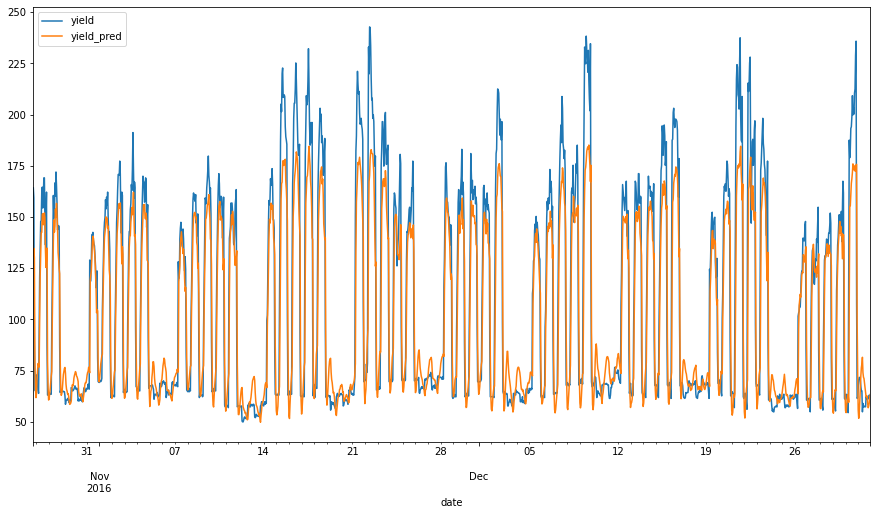

In [ ]:
df_final[['yield','yield_pred']].plot(figsize=(15,8))

# model evaluation

In [ ]:
y_true=df_final['yield']
y_pred=df_final['yield_pred']

In [ ]:
print('RMSE :',sqrt(mean_squared_error(y_true, y_pred)))

RMSE : 19.859314834364458


# Using for loop to train the 10 models on 10 farm ids and saving there weights 

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
import pickle

In [ ]:
# here i created a funtion called 'train_and_evaluate_model' which is used to train and evaulate the models  

In [ ]:

def train_and_evaluate_model(dataframes_dict, model, window_length=168, batch_size=32, num_features=8, scaler=MinMaxScaler()):

    for i in tqdm(dataframes_dict.keys()):
        data = dataframes_dict[i]
        
        # selecting reqired columns
        data_input = data[['yield','farm_area','temp_obs','wind_direction','dew_temp','pressure_sea_level','precipitation','wind_speed']]
        
        #scaling data using min max scaler
        data_scaled = scaler.fit_transform(data_input)
        features = data_scaled
        target = data_scaled[:,0]
       
        #   spliting data into train and test
        X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.20,shuffle=False)

        train_generator = TimeseriesGenerator(X_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
        test_generator = TimeseriesGenerator(X_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)
       
        #MODEL BUILDING
        early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=3,
                                                         mode='min')
        model.compile(loss=tf.losses.MeanSquaredError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.metrics.MeanAbsoluteError()])
        
        history = model.fit_generator(train_generator, epochs=30,
                                      validation_data=test_generator, 
                                      shuffle=False,
                                      callbacks=[early_stoping])
        # saving the model weights 
        pickle.dump(model,open(f"/content/drive/MyDrive/Capstone/Model/LSTM_model_{str(i)}.pkl",'wb'))
        
        #predictions
        predictions = model.predict_generator(test_generator)
        df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][window_length:])], axis=1)
        rev_trans = scaler.inverse_transform(df_pred)
        df_final = data_input[predictions.shape[0]*-1:]
        df_final['yield_pred'] = rev_trans[:,0] 
        # display(df_final)
        y_true = df_final['yield']
        y_pred = df_final['yield_pred']
        df_final[['yield','yield_pred']].plot(figsize=(15,8))

        # evaluation
        print('RMSE :',sqrt(mean_squared_error(y_true, y_pred)))
        for i in ids:
          metrics=get_metrics(y_true,y_pred,i,Metrics)
        print('*'*50)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/30
215/215 [==============================] - 14s 33ms/step - loss: 0.0021 - mean_absolute_error: 0.0326 - val_loss: 0.0076 - val_mean_absolute_error: 0.0798
Epoch 2/30
215/215 [==============================] - 5s 25ms/step - loss: 0.0028 - mean_absolute_error: 0.0379 - val_loss: 0.0075 - val_mean_absolute_error: 0.0778
Epoch 3/30
215/215 [==============================] - 5s 25ms/step - loss: 0.0027 - mean_absolute_error: 0.0374 - val_loss: 0.0045 - val_mean_absolute_error: 0.0577
Epoch 4/30
215/215 [==============================] - 8s 39ms/step - loss: 0.0026 - mean_absolute_error: 0.0362 - val_loss: 0.0035 - val_mean_absolute_error: 0.0495
Epoch 5/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0023 - mean_absolute_error: 0.0342 - val_loss: 0.0035 - val_mean_absolute_error: 0.0497
Epoch 6/30
215/215 [==============================] - 7s 31ms/step - loss: 0.0022 - mean_absolute_error: 0.0338 - val_loss: 0.0037 - val_mean_absolute_error: 0.0507
Epoch 7/3

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,179.513,690.455096,28.9,80.0,16.1,1021.4,0.0,8.2,196.753716
7195,183.609,690.455096,27.2,90.0,16.7,1021.5,0.0,5.1,192.877258
7196,198.625,690.455096,26.7,80.0,17.2,1021.4,0.0,6.7,196.615635
7197,193.165,690.455096,25.6,70.0,18.3,1021.6,-1.0,7.2,205.836620
7198,204.768,690.455096,24.4,60.0,17.2,1022.0,0.0,6.7,203.230793
...,...,...,...,...,...,...,...,...,...
8778,232.071,690.455096,22.8,140.0,10.0,1021.7,0.0,5.7,237.302921
8779,189.069,690.455096,23.3,170.0,8.9,1021.0,0.0,4.1,244.842213
8780,169.958,690.455096,23.3,150.0,10.0,1021.1,0.0,4.1,217.752701
8781,169.958,690.455096,22.8,160.0,10.0,1021.1,0.0,3.1,209.923630


RMSE : 28.397513216409614
**************************************************
Epoch 1/30
215/215 [==============================] - 12s 28ms/step - loss: 0.0032 - mean_absolute_error: 0.0394 - val_loss: 0.0055 - val_mean_absolute_error: 0.0658
Epoch 2/30
215/215 [==============================] - 6s 29ms/step - loss: 0.0034 - mean_absolute_error: 0.0410 - val_loss: 0.0042 - val_mean_absolute_error: 0.0570
Epoch 3/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0034 - mean_absolute_error: 0.0416 - val_loss: 0.0035 - val_mean_absolute_error: 0.0521
Epoch 4/30
215/215 [==============================] - 6s 30ms/step - loss: 0.0030 - mean_absolute_error: 0.0391 - val_loss: 0.0036 - val_mean_absolute_error: 0.0533
Epoch 5/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0029 - mean_absolute_error: 0.0383 - val_loss: 0.0036 - val_mean_absolute_error: 0.0530
Epoch 6/30
215/215 [==============================] - 6s 29ms/step - loss: 0.0030 - mean_absolute

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,30.3057,499.446528,28.9,80.0,16.1,1021.4,0.0,8.2,30.831579
7195,29.4866,499.446528,27.2,90.0,16.7,1021.5,0.0,5.1,27.718722
7196,26.6198,499.446528,26.7,80.0,17.2,1021.4,0.0,6.7,27.038623
7197,23.3436,499.446528,25.6,70.0,18.3,1021.6,-1.0,7.2,24.040274
7198,22.9340,499.446528,24.4,60.0,17.2,1022.0,0.0,6.7,21.159932
...,...,...,...,...,...,...,...,...,...
8778,4.9144,499.446528,22.8,140.0,10.0,1021.7,0.0,5.7,8.197040
8779,5.3240,499.446528,23.3,170.0,8.9,1021.0,0.0,4.1,7.669254
8780,5.7335,499.446528,23.3,150.0,10.0,1021.1,0.0,4.1,8.086894
8781,4.9144,499.446528,22.8,160.0,10.0,1021.1,0.0,3.1,8.448660


RMSE : 3.5150819623443996
**************************************************
Epoch 1/30
215/215 [==============================] - 12s 29ms/step - loss: 0.0018 - mean_absolute_error: 0.0272 - val_loss: 0.0012 - val_mean_absolute_error: 0.0264
Epoch 2/30
215/215 [==============================] - 8s 35ms/step - loss: 0.0016 - mean_absolute_error: 0.0258 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 3/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0017 - mean_absolute_error: 0.0257 - val_loss: 0.0016 - val_mean_absolute_error: 0.0324
Epoch 4/30
215/215 [==============================] - 6s 29ms/step - loss: 0.0016 - mean_absolute_error: 0.0252 - val_loss: 0.0017 - val_mean_absolute_error: 0.0339
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......leaky_re_lu
.........vars
......leaky_re_lu_1
.........vars
......ls

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,432.402,2200.407555,28.9,80.0,16.1,1021.4,0.0,8.2,457.622518
7195,422.163,2200.407555,27.2,90.0,16.7,1021.5,0.0,5.1,450.733057
7196,464.824,2200.407555,26.7,80.0,17.2,1021.4,0.0,6.7,440.406893
7197,434.791,2200.407555,25.6,70.0,18.3,1021.6,-1.0,7.2,481.362375
7198,397.933,2200.407555,24.4,60.0,17.2,1022.0,0.0,6.7,447.690094
...,...,...,...,...,...,...,...,...,...
8778,107.162,2200.407555,22.8,140.0,10.0,1021.7,0.0,5.7,142.811591
8779,107.162,2200.407555,23.3,170.0,8.9,1021.0,0.0,4.1,145.067802
8780,106.821,2200.407555,23.3,150.0,10.0,1021.1,0.0,4.1,146.301420
8781,104.090,2200.407555,22.8,160.0,10.0,1021.1,0.0,3.1,147.465911


RMSE : 38.43832176031336
**************************************************
Epoch 1/30
215/215 [==============================] - 15s 48ms/step - loss: 0.0019 - mean_absolute_error: 0.0280 - val_loss: 0.0045 - val_mean_absolute_error: 0.0548
Epoch 2/30
215/215 [==============================] - 9s 42ms/step - loss: 0.0018 - mean_absolute_error: 0.0277 - val_loss: 0.0031 - val_mean_absolute_error: 0.0428
Epoch 3/30
215/215 [==============================] - 7s 31ms/step - loss: 0.0016 - mean_absolute_error: 0.0256 - val_loss: 0.0029 - val_mean_absolute_error: 0.0407
Epoch 4/30
215/215 [==============================] - 6s 26ms/step - loss: 0.0017 - mean_absolute_error: 0.0265 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387
Epoch 5/30
215/215 [==============================] - 6s 30ms/step - loss: 0.0016 - mean_absolute_error: 0.0256 - val_loss: 0.0027 - val_mean_absolute_error: 0.0371
Epoch 6/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0017 - mean_absolute_

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,136.2390,252.69616,28.9,80.0,16.1,1021.4,0.0,8.2,124.561253
7195,101.8380,252.69616,27.2,90.0,16.7,1021.5,0.0,5.1,128.373862
7196,95.5584,252.69616,26.7,80.0,17.2,1021.4,0.0,6.7,113.400226
7197,95.0124,252.69616,25.6,70.0,18.3,1021.6,-1.0,7.2,107.158658
7198,92.5552,252.69616,24.4,60.0,17.2,1022.0,0.0,6.7,102.817862
...,...,...,...,...,...,...,...,...,...
8778,68.2560,252.69616,22.8,140.0,10.0,1021.7,0.0,5.7,122.344277
8779,52.4206,252.69616,23.3,170.0,8.9,1021.0,0.0,4.1,92.573141
8780,53.5127,252.69616,23.3,150.0,10.0,1021.1,0.0,4.1,81.381654
8781,54.3318,252.69616,22.8,160.0,10.0,1021.1,0.0,3.1,71.979165


RMSE : 12.767899467998783
**************************************************
Epoch 1/30
215/215 [==============================] - 13s 37ms/step - loss: 7.1783e-04 - mean_absolute_error: 0.0185 - val_loss: 1.3400e-04 - val_mean_absolute_error: 0.0091
Epoch 2/30
215/215 [==============================] - 5s 25ms/step - loss: 9.0194e-04 - mean_absolute_error: 0.0212 - val_loss: 2.6079e-04 - val_mean_absolute_error: 0.0133
Epoch 3/30
215/215 [==============================] - 6s 30ms/step - loss: 6.7979e-04 - mean_absolute_error: 0.0180 - val_loss: 1.7527e-04 - val_mean_absolute_error: 0.0106
Epoch 4/30
215/215 [==============================] - 5s 25ms/step - loss: 6.8455e-04 - mean_absolute_error: 0.0180 - val_loss: 4.0635e-04 - val_mean_absolute_error: 0.0177
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......leaky_re_lu
.........vars
......leak

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,1533.03,10833.140121,28.9,80.0,16.1,1021.4,0.0,8.2,1568.249964
7195,1491.39,10833.140121,27.2,90.0,16.7,1021.5,0.0,5.1,1538.873961
7196,1478.43,10833.140121,26.7,80.0,17.2,1021.4,0.0,6.7,1501.362591
7197,1447.71,10833.140121,25.6,70.0,18.3,1021.6,-1.0,7.2,1487.901275
7198,1437.47,10833.140121,24.4,60.0,17.2,1022.0,0.0,6.7,1464.957047
...,...,...,...,...,...,...,...,...,...
8778,1150.80,10833.140121,22.8,140.0,10.0,1021.7,0.0,5.7,1204.068202
8779,1197.89,10833.140121,23.3,170.0,8.9,1021.0,0.0,4.1,1201.165008
8780,1147.38,10833.140121,23.3,150.0,10.0,1021.1,0.0,4.1,1228.621605
8781,1130.32,10833.140121,22.8,160.0,10.0,1021.1,0.0,3.1,1189.651465


RMSE : 72.40812800858082
**************************************************
Epoch 1/30
215/215 [==============================] - 12s 29ms/step - loss: 0.0051 - mean_absolute_error: 0.0483 - val_loss: 0.0092 - val_mean_absolute_error: 0.0731
Epoch 2/30
215/215 [==============================] - 6s 30ms/step - loss: 0.0050 - mean_absolute_error: 0.0488 - val_loss: 0.0096 - val_mean_absolute_error: 0.0766
Epoch 3/30
215/215 [==============================] - 5s 25ms/step - loss: 0.0050 - mean_absolute_error: 0.0493 - val_loss: 0.0107 - val_mean_absolute_error: 0.0788
Epoch 4/30
215/215 [==============================] - 7s 31ms/step - loss: 0.0049 - mean_absolute_error: 0.0488 - val_loss: 0.0060 - val_mean_absolute_error: 0.0595
Epoch 5/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0042 - mean_absolute_error: 0.0446 - val_loss: 0.0090 - val_mean_absolute_error: 0.0717
Epoch 6/30
215/215 [==============================] - 5s 25ms/step - loss: 0.0038 - mean_absolute_

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,19.7942,743.224,28.9,80.0,16.1,1021.4,0.0,8.2,25.917998
7195,12.6274,743.224,27.2,90.0,16.7,1021.5,0.0,5.1,14.360445
7196,16.7227,743.224,26.7,80.0,17.2,1021.4,0.0,6.7,20.971844
7197,8.1907,743.224,25.6,70.0,18.3,1021.6,-1.0,7.2,13.121511
7198,15.0163,743.224,24.4,60.0,17.2,1022.0,0.0,6.7,14.793248
...,...,...,...,...,...,...,...,...,...
8778,10.2384,743.224,22.8,140.0,10.0,1021.7,0.0,5.7,25.319081
8779,18.7704,743.224,23.3,170.0,8.9,1021.0,0.0,4.1,13.423460
8780,9.2146,743.224,23.3,150.0,10.0,1021.1,0.0,4.1,22.193212
8781,17.4053,743.224,22.8,160.0,10.0,1021.1,0.0,3.1,10.235067


RMSE : 7.382812152217315
**************************************************
Epoch 1/30
215/215 [==============================] - 12s 34ms/step - loss: 9.4812e-04 - mean_absolute_error: 0.0218 - val_loss: 0.0068 - val_mean_absolute_error: 0.0591
Epoch 2/30
215/215 [==============================] - 6s 29ms/step - loss: 7.8313e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0037 - val_mean_absolute_error: 0.0433
Epoch 3/30
215/215 [==============================] - 7s 33ms/step - loss: 5.6113e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0054 - val_mean_absolute_error: 0.0549
Epoch 4/30
215/215 [==============================] - 5s 25ms/step - loss: 5.4065e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0041 - val_mean_absolute_error: 0.0484
Epoch 5/30
215/215 [==============================] - 7s 32ms/step - loss: 5.1144e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0033 - val_mean_absolute_error: 0.0440
Epoch 6/30
215/215 [==============================] - 5s 24ms/step - loss: 5.0

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,123.680,2594.409178,28.9,80.0,16.1,1021.4,0.0,8.2,115.245039
7195,126.137,2594.409178,27.2,90.0,16.7,1021.5,0.0,5.1,121.906640
7196,124.909,2594.409178,26.7,80.0,17.2,1021.4,0.0,6.7,122.274748
7197,124.909,2594.409178,25.6,70.0,18.3,1021.6,-1.0,7.2,119.691332
7198,126.547,2594.409178,24.4,60.0,17.2,1022.0,0.0,6.7,119.791530
...,...,...,...,...,...,...,...,...,...
8778,264.970,2594.409178,22.8,140.0,10.0,1021.7,0.0,5.7,194.434708
8779,265.379,2594.409178,23.3,170.0,8.9,1021.0,0.0,4.1,207.461266
8780,263.741,2594.409178,23.3,150.0,10.0,1021.1,0.0,4.1,198.729299
8781,258.827,2594.409178,22.8,160.0,10.0,1021.1,0.0,3.1,202.805025


RMSE : 14.842139623367364
**************************************************
Epoch 1/30
215/215 [==============================] - 12s 29ms/step - loss: 0.0012 - mean_absolute_error: 0.0228 - val_loss: 7.1708e-04 - val_mean_absolute_error: 0.0196
Epoch 2/30
215/215 [==============================] - 7s 31ms/step - loss: 0.0013 - mean_absolute_error: 0.0245 - val_loss: 6.8921e-04 - val_mean_absolute_error: 0.0193
Epoch 3/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0010 - mean_absolute_error: 0.0213 - val_loss: 6.8805e-04 - val_mean_absolute_error: 0.0193
Epoch 4/30
215/215 [==============================] - 6s 29ms/step - loss: 9.9996e-04 - mean_absolute_error: 0.0212 - val_loss: 6.8325e-04 - val_mean_absolute_error: 0.0193
Epoch 5/30
215/215 [==============================] - 6s 26ms/step - loss: 9.2297e-04 - mean_absolute_error: 0.0204 - val_loss: 6.9082e-04 - val_mean_absolute_error: 0.0196
Epoch 6/30
215/215 [==============================] - 5s 25ms/step - 

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,667.544,11248.137822,28.9,80.0,16.1,1021.4,0.0,8.2,669.533811
7195,652.528,11248.137822,27.2,90.0,16.7,1021.5,0.0,5.1,620.486293
7196,607.137,11248.137822,26.7,80.0,17.2,1021.4,0.0,6.7,598.018177
7197,534.786,11248.137822,25.6,70.0,18.3,1021.6,-1.0,7.2,549.111776
7198,474.721,11248.137822,24.4,60.0,17.2,1022.0,0.0,6.7,495.484817
...,...,...,...,...,...,...,...,...,...
8778,550.826,11248.137822,22.8,140.0,10.0,1021.7,0.0,5.7,574.487703
8779,593.145,11248.137822,23.3,170.0,8.9,1021.0,0.0,4.1,541.896250
8780,557.993,11248.137822,23.3,150.0,10.0,1021.1,0.0,4.1,574.297287
8781,551.850,11248.137822,22.8,160.0,10.0,1021.1,0.0,3.1,550.122796


RMSE : 29.08030649273556
**************************************************
Epoch 1/30
215/215 [==============================] - 13s 33ms/step - loss: 9.7323e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0018 - val_mean_absolute_error: 0.0295
Epoch 2/30
215/215 [==============================] - 6s 28ms/step - loss: 0.0011 - mean_absolute_error: 0.0234 - val_loss: 0.0018 - val_mean_absolute_error: 0.0293
Epoch 3/30
215/215 [==============================] - 7s 31ms/step - loss: 0.0010 - mean_absolute_error: 0.0225 - val_loss: 0.0018 - val_mean_absolute_error: 0.0296
Epoch 4/30
215/215 [==============================] - 5s 25ms/step - loss: 9.6443e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0015 - val_mean_absolute_error: 0.0275
Epoch 5/30
215/215 [==============================] - 5s 25ms/step - loss: 0.0010 - mean_absolute_error: 0.0227 - val_loss: 0.0016 - val_mean_absolute_error: 0.0277
Epoch 6/30
215/215 [==============================] - 6s 26ms/step - loss: 0.0011 - mean_a

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
7194,422.505,5649.338527,28.9,80.0,16.1,1021.4,0.0,8.2,399.155163
7195,435.132,5649.338527,27.2,90.0,16.7,1021.5,0.0,5.1,412.229524
7196,434.108,5649.338527,26.7,80.0,17.2,1021.4,0.0,6.7,413.269637
7197,427.965,5649.338527,25.6,70.0,18.3,1021.6,-1.0,7.2,402.855113
7198,377.797,5649.338527,24.4,60.0,17.2,1022.0,0.0,6.7,402.577875
...,...,...,...,...,...,...,...,...,...
8778,555.604,5649.338527,22.8,140.0,10.0,1021.7,0.0,5.7,492.709000
8779,577.446,5649.338527,23.3,170.0,8.9,1021.0,0.0,4.1,500.994324
8780,540.246,5649.338527,23.3,150.0,10.0,1021.1,0.0,4.1,506.515879
8781,513.968,5649.338527,22.8,160.0,10.0,1021.1,0.0,3.1,481.173468


RMSE : 32.01556686383507
**************************************************
Epoch 1/30
215/215 [==============================] - 12s 35ms/step - loss: 0.0022 - mean_absolute_error: 0.0316 - val_loss: 0.0072 - val_mean_absolute_error: 0.0586
Epoch 2/30
215/215 [==============================] - 6s 27ms/step - loss: 0.0022 - mean_absolute_error: 0.0314 - val_loss: 0.0071 - val_mean_absolute_error: 0.0592
Epoch 3/30
215/215 [==============================] - 7s 30ms/step - loss: 0.0021 - mean_absolute_error: 0.0309 - val_loss: 0.0073 - val_mean_absolute_error: 0.0605
Epoch 4/30
215/215 [==============================] - 5s 24ms/step - loss: 0.0021 - mean_absolute_error: 0.0302 - val_loss: 0.0068 - val_mean_absolute_error: 0.0563
Epoch 5/30
215/215 [==============================] - 7s 31ms/step - loss: 0.0021 - mean_absolute_error: 0.0301 - val_loss: 0.0066 - val_mean_absolute_error: 0.0551
Epoch 6/30
215/215 [==============================] - 5s 25ms/step - loss: 0.0020 - mean_absolute_

,yield,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,yield_pred
date,,,,,,,,,
2016-10-26 19:00:00,164.2240,2508.381,28.9,80.0,16.1,1021.4,0.0,8.2,133.524829
2016-10-26 20:00:00,159.3100,2508.381,27.2,90.0,16.7,1021.5,0.0,5.1,143.433698
2016-10-26 21:00:00,89.2789,2508.381,26.7,80.0,17.2,1021.4,0.0,6.7,139.133380
2016-10-26 22:00:00,65.5258,2508.381,25.6,70.0,18.3,1021.6,-1.0,7.2,82.715620
2016-10-26 23:00:00,65.1162,2508.381,24.4,60.0,17.2,1022.0,0.0,6.7,74.052625
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,61.4304,2508.381,22.8,140.0,10.0,1021.7,0.0,5.7,62.446203
2016-12-31 20:00:00,61.4304,2508.381,23.3,170.0,8.9,1021.0,0.0,4.1,61.676581
2016-12-31 21:00:00,63.0686,2508.381,23.3,150.0,10.0,1021.1,0.0,4.1,62.506587


RMSE : 19.81977978338888
**************************************************


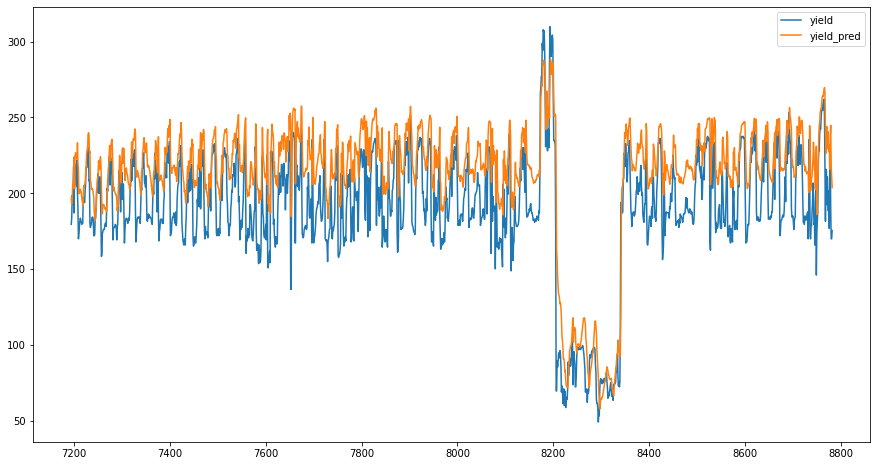

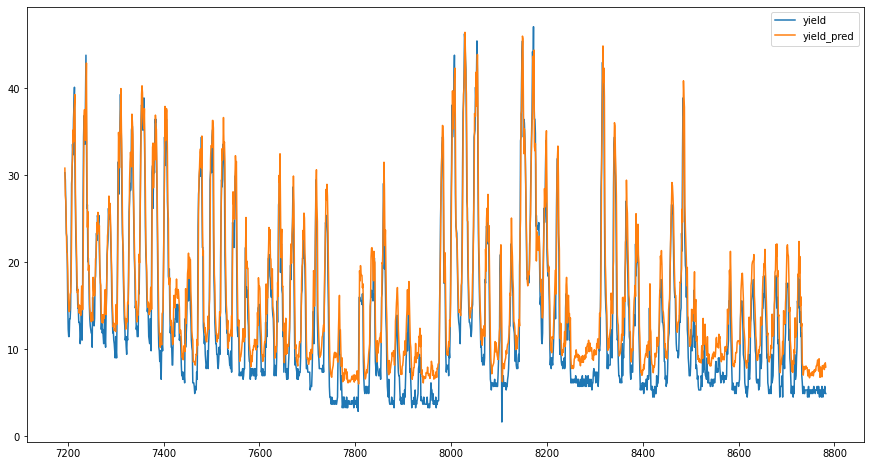

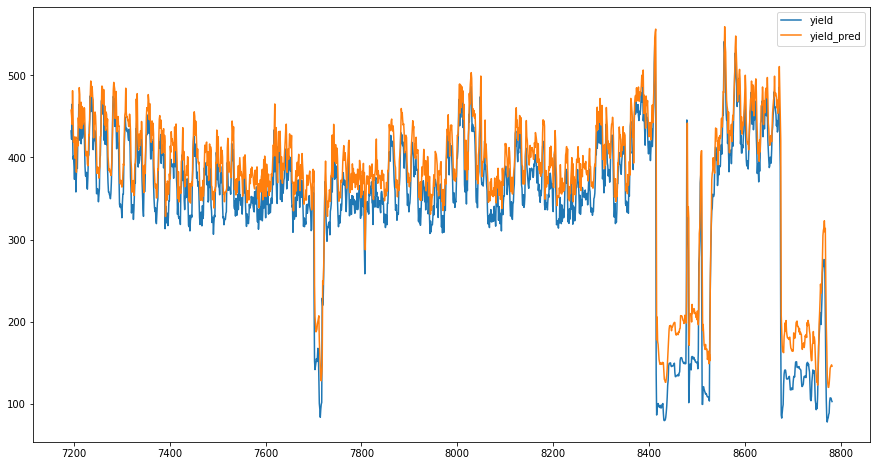

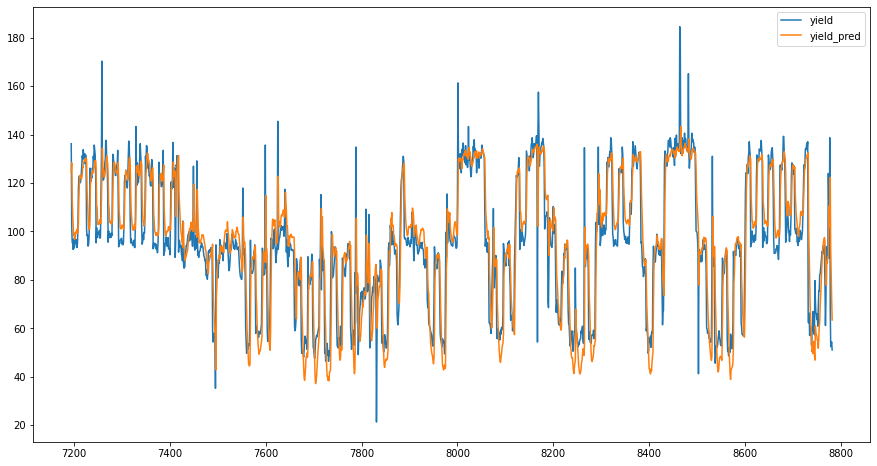

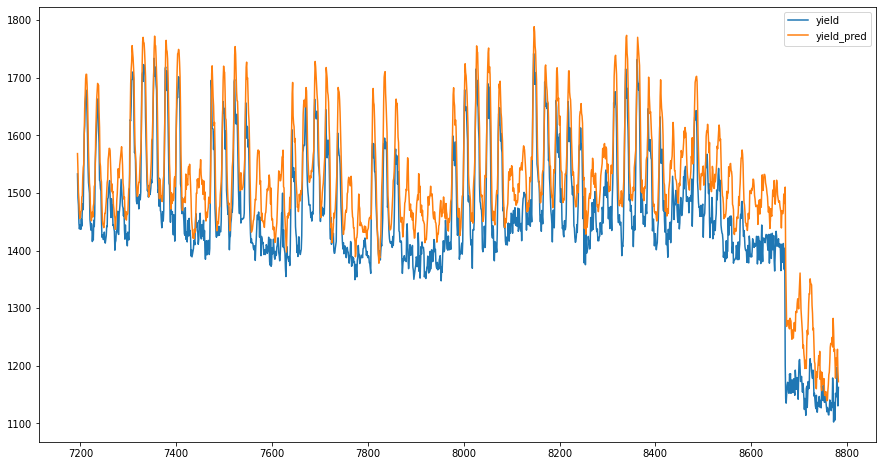

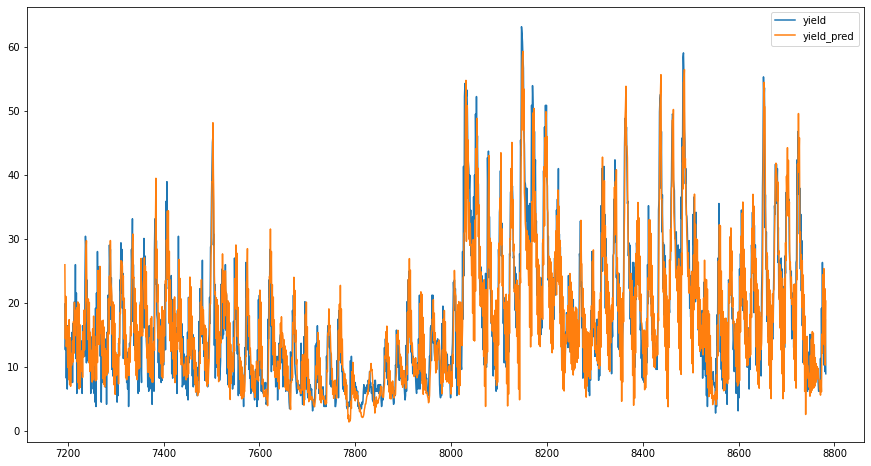

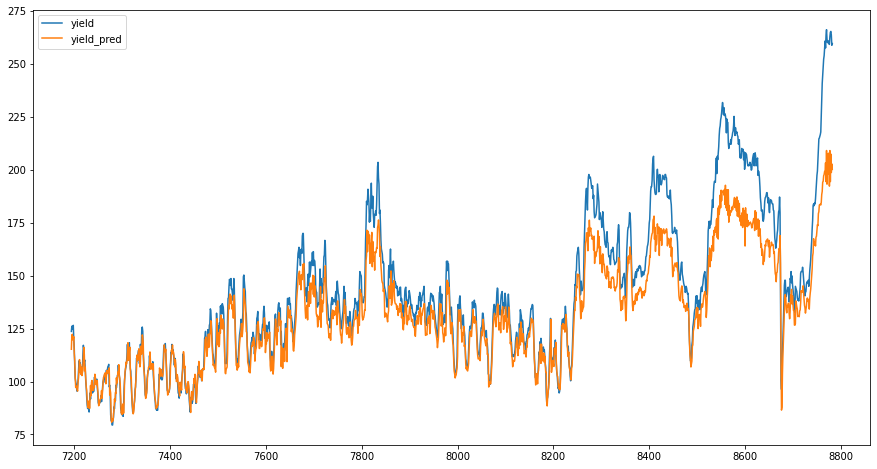

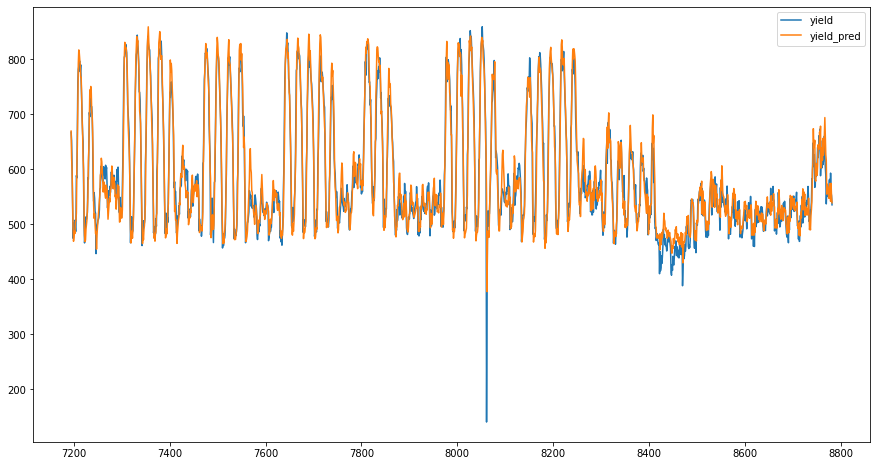

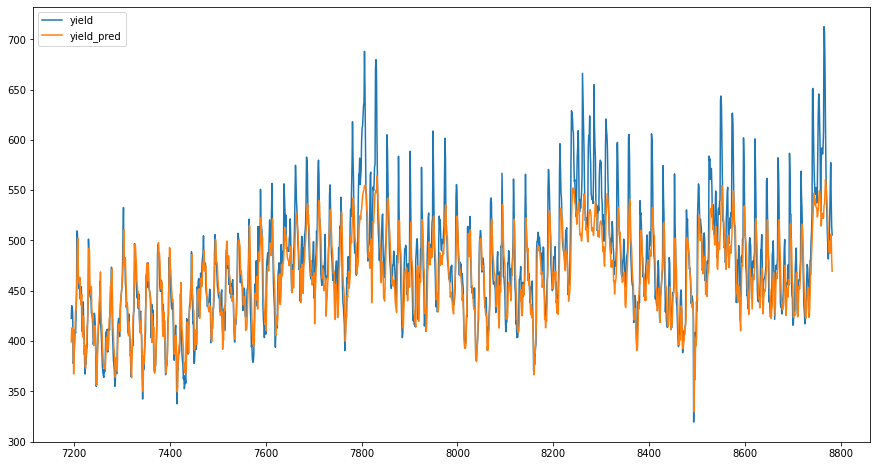

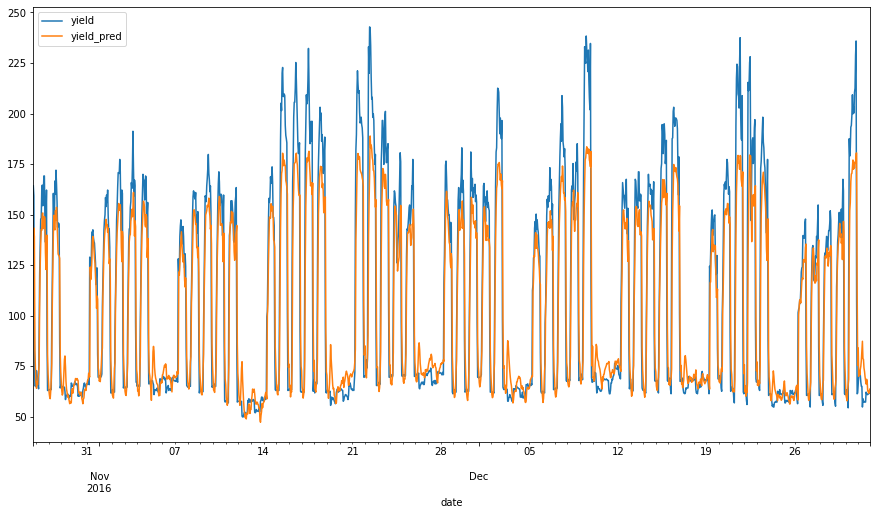

In [ ]:
# calling the funtion
train_and_evaluate_model(dataframes_dict=dataframes_dict, model=model)

# **Test**

#### here also i created a 10 subsets of same farms ids for which i trained the models ,and i am  using them for predictions

In [ ]:
path='/content/drive/MyDrive/Capstone/farm_ids/test_farm_ids'

In [ ]:
# create empty list
list_of_names=[] 
#The glob.glob function is used to search for all files in the directory specified by path 
#that match the pattern *.csv
for i in glob.glob(path+'/'+"*.csv"):
  list_of_names.append(i) 

In [ ]:
#create empty list
test_dataframes_dict ={}
#For each iteration of the loop, the line temp_df=pd.read_csv(list_of_names[i]) reads the .csv file 
#at the index i of the list list_of_names into a pandas dataframe 
for i in range (len(list_of_names)):
  temp_df=pd.read_csv(list_of_names[i])
  # dataframes_list.append(temp_df)
  test_dataframes_dict[i]=temp_df

In [ ]:
test_dataframes_dict  # it displayes the 10 farm ids test data

{0:                      date     farm_id ingredient_type       id   farm_area  \
 0     2017-01-01 00:00:00  fid_110884           ing_w        0  690.455096   
 1     2017-01-01 01:00:00  fid_110884           ing_w      129  690.455096   
 2     2017-01-01 02:00:00  fid_110884           ing_w      258  690.455096   
 3     2017-01-01 03:00:00  fid_110884           ing_w      387  690.455096   
 4     2017-01-01 04:00:00  fid_110884           ing_w      516  690.455096   
 ...                   ...         ...             ...      ...         ...   
 8755  2017-12-31 19:00:00  fid_110884           ing_w  1129395  690.455096   
 8756  2017-12-31 20:00:00  fid_110884           ing_w  1129524  690.455096   
 8757  2017-12-31 21:00:00  fid_110884           ing_w  1129653  690.455096   
 8758  2017-12-31 22:00:00  fid_110884           ing_w  1129782  690.455096   
 8759  2017-12-31 23:00:00  fid_110884           ing_w  1129911  690.455096   
 
      farming_company deidentified_location  te

#### test on one farm id

In [ ]:
test_dataframes_dict[9]

,date,farm_id,ingredient_type,id,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2017-01-01 00:00:00,fid_32954,ing_w,10,2508.381,Wayne Farms,location 7369,17.8,100.000000,11.7,1021.4,0.0,3.6
1,2017-01-01 01:00:00,fid_32954,ing_w,139,2508.381,Wayne Farms,location 7369,17.8,130.000000,12.8,1022.0,0.0,3.1
2,2017-01-01 02:00:00,fid_32954,ing_w,268,2508.381,Wayne Farms,location 7369,16.1,140.000000,12.8,1021.9,0.0,3.1
3,2017-01-01 03:00:00,fid_32954,ing_w,397,2508.381,Wayne Farms,location 7369,17.2,140.000000,13.3,1022.2,0.0,3.1
4,2017-01-01 04:00:00,fid_32954,ing_w,526,2508.381,Wayne Farms,location 7369,16.7,130.000000,13.3,1022.3,0.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,fid_32954,ing_w,1129405,2508.381,Wayne Farms,location 7369,19.4,130.000000,7.2,1019.4,0.0,2.6
8756,2017-12-31 20:00:00,fid_32954,ing_w,1129534,2508.381,Wayne Farms,location 7369,20.0,136.717557,8.3,1019.1,0.0,1.5
8757,2017-12-31 21:00:00,fid_32954,ing_w,1129663,2508.381,Wayne Farms,location 7369,20.0,210.000000,8.9,1019.2,0.0,1.5
8758,2017-12-31 22:00:00,fid_32954,ing_w,1129792,2508.381,Wayne Farms,location 7369,20.0,150.000000,8.9,1019.2,0.0,1.5


In [ ]:
test_data = test_dataframes_dict[9]
# selecting reqired columns
test_input = test_data[['farm_area','temp_obs','wind_direction','dew_temp','id','pressure_sea_level','precipitation','wind_speed']]
        
        #scaling data using min max scaler
test_scaled = scaler.fit_transform(test_input)
test_features = test_scaled
test = TimeseriesGenerator(features,features, length=window_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
test_pred=model.predict_generator(test) # using model.predict_generator predicting on test
test_pred

array([[0.01978574],
       [0.01962851],
       [0.01960589],
       ...,
       [0.02631735],
       [0.02534899],
       [0.02417288]], dtype=float32)

In [ ]:
test_pred=pd.concat([pd.DataFrame(test_pred),pd.DataFrame(test_features[:,1:][len(test_pred):])],axis=1)
test_pred

,0,0,1,2,3,4,5,6
0,0.019786,0.442073,0.138889,0.552279,0.983561,0.766727,0.001672,0.235537
1,0.019629,0.371951,0.166667,0.522788,0.983675,0.795660,0.001672,0.210744
2,0.019606,0.338415,0.083333,0.506702,0.983789,0.808318,0.001672,0.210744
3,0.019796,0.338415,0.083333,0.477212,0.983903,0.811935,0.001672,0.210744
4,0.020054,0.304878,1.000000,0.493298,0.984017,0.819168,0.001672,0.169421
...,...,...,...,...,...,...,...,...
8610,0.027393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8611,0.027021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8612,0.026317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8613,0.025349,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# inverse trasformation
test_rev_trans=scaler.inverse_transform(test_pred)

In [ ]:
test_df_final=test_input[test_pred.shape[0]*-1:] 

In [ ]:
test_df_final['yield_pred']=test_rev_trans[:,0]  # selects all the elements in the first column of the array and it to dataframe

In [ ]:
test_df_final

,farm_area,temp_obs,wind_direction,dew_temp,id,pressure_sea_level,precipitation,wind_speed,yield_pred
145,2508.381,21.1,150.000000,12.8,18715,1014.5,0.0,3.6,2508.400786
146,2508.381,21.1,160.000000,14.4,18844,1014.9,-1.0,4.1,2508.400629
147,2508.381,21.1,180.000000,15.0,18973,1014.7,-1.0,3.1,2508.400606
148,2508.381,19.4,0.000000,17.2,19102,1015.2,8.0,0.0,2508.400796
149,2508.381,18.9,0.000000,17.2,19231,1014.3,79.0,0.0,2508.401054
...,...,...,...,...,...,...,...,...,...
8755,2508.381,19.4,130.000000,7.2,1129405,1019.4,0.0,2.6,2508.408393
8756,2508.381,20.0,136.717557,8.3,1129534,1019.1,0.0,1.5,2508.408021
8757,2508.381,20.0,210.000000,8.9,1129663,1019.2,0.0,1.5,2508.407317
8758,2508.381,20.0,150.000000,8.9,1129792,1019.2,0.0,1.5,2508.406349


# using for loop for testing 10 farm ids and saving predictions

In [ ]:
# Creating empty dictionary for saving model predictions
predict={} 
for i in tqdm(dataframes_dict.keys()):
        test_data = test_dataframes_dict[i]
        # selecting reqired columns
        test_input = test_data[['id','farm_area','temp_obs','wind_direction','dew_temp','pressure_sea_level','precipitation','wind_speed']]
        
        #scaling data using min max scaler
        test_scaled = scaler.fit_transform(test_input)
        test_features = test_scaled
        test = TimeseriesGenerator(features,features, length=window_length, sampling_rate=1, batch_size=batch_size)
        
        #predictions
        test_pred=model.predict_generator(test)
        
        pred=pd.concat([pd.DataFrame(test_pred),pd.DataFrame(test_features[:,1:][len(test_pred):])],axis=1)
       
        #inverse transformation
        test_rev_trans=scaler.inverse_transform(pred)
        test_df_final=test_input[test_pred.shape[0]*-1:]
        test_df_final['yield_pred']=test_rev_trans[:,0]
        #display(test_df_final)   

        
        #converting predictions to csv file
        sub=test_df_final[['id','yield_pred']]
        predict[i]=sub


  0%|          | 0/10 [00:00<?, ?it/s]

#### saving all prediction subsets into one dataframe

In [ ]:
pred=[]
for i in predict.values():
  pred.append(i)
main=pd.concat(pred)


In [ ]:
main

,id,yield_pred
145,18705,22356.128892
146,18834,22178.473435
147,18963,22152.908577
148,19092,22368.274673
149,19221,22658.843167
...,...,...
8755,1129405,30961.807958
8756,1129534,30540.799498
8757,1129663,29746.233369
8758,1129792,28652.082806


# submission

In [ ]:
#reading the submission file 
submission=pd.read_csv('/content/drive/MyDrive/Capstone/sample_submission-1646898326432-1664166963268.csv')

In [ ]:
submission

,id,yield
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
20848795,41696845,0
20848796,41696846,0
20848797,41696847,0
20848798,41696848,0


In [ ]:
# using merge for combining predictions with submission file
final_sub=pd.merge(submission,main,on='id',how='left')


In [ ]:
#droping yield column from submission dataframe because it is not usefull here
final_sub.drop(['yield'],inplace=True,axis=1)

In [ ]:
# replaying the column name 
final_sub.rename(columns={'yield_pred' : 'yield'},inplace=True)

In [ ]:
final_sub #final submission dataframe

,id,yield
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
20848795,41696845,27323.178565
20848796,41696846,27323.178565
20848797,41696847,27323.178565
20848798,41696848,27323.178565


# converting predictions to csv

In [ ]:
final_sub.to_csv('/content/drive/MyDrive/Capstone/predictions/submission_file.csv',index=False)

# Same procedure is follwed for all 1434 farm ids, because of lack of computation power I did it only for 10 farm ids.

# If I could have more time I will finish this.

# END

# Rough work


In [ ]:
final_sub['yield_pred']=final_sub['yield_pred'].interpolate()

In [ ]:
ids=['fid_110884','fid_17537','fid_110392','fid_90053','fid_62402',
     'fid_121604','fid_85694','fid_33785','fid_110793','fid_32954']

In [ ]:
for i in ids:
  print(i)

fid_110884
fid_17537
fid_110392
fid_90053
fid_62402
fid_121604
fid_85694
fid_33785
fid_110793
fid_32954


In [ ]:
for i,j in predict,ids:   #The for loop iterates over each element i in the sequence subsets.
  predict[i].to_csv(path+'/'+j+'.csv')

In [ ]:
import pickle

# Define a list of model filenames
model_filenames = ['/content/drive/MyDrive/Capstone/Model/LSTM_model_{}.pkl'.format(i) for i in range(10)]

# Load each model using pickle.load() and store in a list
models = []
for filename in model_filenames:
    with open(filename, 'rb') as f:
        model = pickle.load(f)
        models.append(model)

# Define the test data as a dictionary
test_data = predict
# Use the loaded models to make predictions on each value in the test data dictionary
predictions = {}
for i in test_data:
    feature_values = test_data[i]
    model = models[i]
    predictions[i] = model.predict(feature_values)

# Print the predictions
for i in predictions:
    print(f"Predictions for {i}: {predictions[i]}")


Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-02-24 09:20:52      3057880
metadata.json                                  2023-02-24 09:20:52           64
config.json                                    2023-02-24 09:20:52         4715
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......leaky_re_lu
.........vars
......leaky_re_lu_1
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_2
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......me

In [ ]:
predictions

{0: array([[0.05871934],
        [0.05806884],
        [0.0574899 ],
        ...,
        [0.30514145],
        [0.304391  ],
        [0.29973066]], dtype=float32), 1: array([[0.06821388],
        [0.06720057],
        [0.06662166],
        ...,
        [0.26273143],
        [0.26991725],
        [0.2645002 ]], dtype=float32), 2: array([[0.04760592],
        [0.04665318],
        [0.04593985],
        ...,
        [0.29714882],
        [0.30416232],
        [0.29637054]], dtype=float32), 3: array([[0.03593755],
        [0.0365414 ],
        [0.03737459],
        ...,
        [0.22340894],
        [0.22801447],
        [0.22665638]], dtype=float32), 4: array([[0.02638321],
        [0.0260397 ],
        [0.02569546],
        ...,
        [0.2519558 ],
        [0.25682434],
        [0.25141898]], dtype=float32), 5: array([[0.02646324],
        [0.0253882 ],
        [0.02454604],
        ...,
        [0.22447358],
        [0.23112783],
        [0.22473384]], dtype=float32), 6: array([[0.01

In [ ]:
predictions[1]

array([[0.06821388],
       [0.06720057],
       [0.06662166],
       ...,
       [0.26273143],
       [0.26991725],
       [0.2645002 ]], dtype=float32)

In [ ]:
predictions[2]

array([[0.04760592],
       [0.04665318],
       [0.04593985],
       ...,
       [0.29714882],
       [0.30416232],
       [0.29637054]], dtype=float32)

In [ ]:
test_df_final['yield_pred']=test_rev_trans[:,0]

In [ ]:
predict1={}
for i in predictions.keys():
  test_data=predictions[i]

  pred=pd.concat([pd.DataFrame(test_pred),pd.DataFrame(test_features[:,1:][len(test_pred):])],axis=1)
       
  #inverse transformation
  test_rev_trans=scaler.inverse_transform(pred)
  test_df_final=test_input[test_pred.shape[0]*-1:]
  test_df_final['yield_pred']=test_rev_trans[:,0]
        #display(test_df_final)   

        
        #converting predictions to csv file
  sub=test_df_final[['id','yield_pred']]
  display(sub)
        #pred.append(sub)
        # sub=pd.concat(sub,sub)
  predict1[i]=sub
        # display(sub)


ValueError: ignored

# Rough Work

In [ ]:
train_generator[0]

(array([[[0.        , 0.        , 0.65988372, ..., 0.7382199 ,
          0.        , 0.0974026 ],
         [0.        , 0.        , 0.61337209, ..., 0.7382199 ,
          0.00290698, 0.        ],
         [0.        , 0.        , 0.56395349, ..., 0.73560209,
          0.00290698, 0.        ],
         ...,
         [0.        , 0.        , 0.56395349, ..., 0.57068063,
          0.00290698, 0.16883117],
         [0.        , 0.        , 0.5494186 , ..., 0.58115183,
          0.00290698, 0.13636364],
         [0.        , 0.        , 0.51453488, ..., 0.59424084,
          0.00290698, 0.16883117]],
 
        [[0.        , 0.        , 0.61337209, ..., 0.7382199 ,
          0.00290698, 0.        ],
         [0.        , 0.        , 0.56395349, ..., 0.73560209,
          0.00290698, 0.        ],
         [0.        , 0.        , 0.53197674, ..., 0.73298429,
          0.        , 0.16883117],
         ...,
         [0.        , 0.        , 0.5494186 , ..., 0.58115183,
          0.00290698, 0.

In [ ]:
predictions.shape[0]

In [ ]:
predict={}
for i in tqdm(dataframes_dict.keys()):
        test_data = test_dataframes_dict[i]
        # selecting reqired columns
        test_input = test_data[['id','farm_area','temp_obs','wind_direction','dew_temp','pressure_sea_level','precipitation','wind_speed']]
        
        #scaling data using min max scaler
        test_scaled = scaler.fit_transform(test_input)
        test_features = test_scaled
        test = TimeseriesGenerator(features,features, length=window_length, sampling_rate=1, batch_size=batch_size)
        
        predict[i]=test
        display(test)
        # test_pred=model.predict_generator(test)
        
        # pred=pd.concat([pd.DataFrame(test_pred[i]),pd.DataFrame(test_features[:,1:][len(test_pred[i]):])],axis=1)
       
        # #inverse transformation
        # test_rev_trans=scaler.inverse_transform(pred)
        # test_df_final=test_input[test_pred.shape[0]*-1:]
        # test_df_final['yield_pred']=test_rev_trans[:,0]
        # #display(test_df_final)   

        
        # #converting predictions to csv file
        # sub=test_df_final[['id','yield_pred']]
        # display(sub)
        # #pred.append(sub)
        # # sub=pd.concat(sub,sub)
        # predict[i]=sub
        # # display(sub)


In [ ]:
ids=['fid_110884', 'fid_90053', 'fid_17537', 'fid_110392', 'fid_62402',
       'fid_121604', 'fid_85694', 'fid_33785', 'fid_110793', 'fid_32954']